# (MBTI) Myers-Briggs Personality Type Prediction

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

* Introversion (I) – Extroversion (E)
* Intuition (N) – Sensing (S)
* Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)


So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

It is one of, if not the, the most popular personality test in the world. It is used in businesses, online, for fun, for research and lots more. A simple google search reveals all of the different ways the test has been used over time. It’s safe to say that this test is still very relevant in the world in terms of its use.

From scientific or psychological perspective it is based on the work done on cognitive functions by Carl Jung i.e. Jungian Typology. This was a model of 8 distinct functions, thought processes or ways of thinking that were suggested to be present in the mind. Later this work was transformed into several different personality systems to make it more accessible, the most popular of which is of course the MBTI.

Recently, its use/validity has come into question because of unreliability in experiments surrounding it, among other reasons. But it is still clung to as being a very useful tool in a lot of areas, and the purpose of this dataset is to help see if any patterns can be detected in specific types and their style of writing, which overall explores the validity of the test in analysing, predicting or categorising behaviour.

Content:<br>
This dataset contains over 8600 rows of data, on each row is a person’s:
* Type (This persons 4 letter MBTI code/type)
* A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

In [1]:
# importing dependencies here
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# cleaning and dropping stop words
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")

# lemmitizing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("vader_lexicon")

# # performance check
import time

# code formatter
%load_ext nb_black

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\eshom\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<IPython.core.display.Javascript object>

In [2]:
# reading the dataset
personality_data = pd.read_csv("../data/mbti_1.csv")

<IPython.core.display.Javascript object>

In [3]:
# lookign at the top 5 rows of the dataset
personality_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


<IPython.core.display.Javascript object>

In [4]:
# checking the number of rows and columns
personality_data.shape

(8675, 2)

<IPython.core.display.Javascript object>

#### Checking for Null values

In [5]:
# checking for missing values
personality_data.isnull().sum()

type     0
posts    0
dtype: int64

<IPython.core.display.Javascript object>

Luckily there are no missing values present in this dataset.

#### Checking for Class Imbalance

In [6]:
# checking number of records for each of the 16 personality types
personality_data["type"].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

<IPython.core.display.Javascript object>

The dataset seems to be Imbalanced.

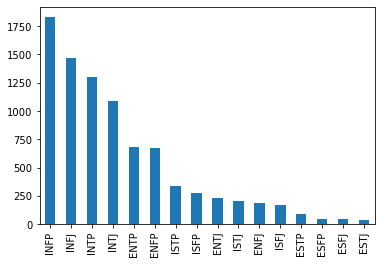

<IPython.core.display.Javascript object>

In [7]:
# visually showing the class imbalance
personality_data["type"].value_counts().plot(kind="bar")
plt.show()

In [8]:
# to handle the class imbalance better, converting the 16 classes into 4 more balanced classes

personality_data["is_Extrovert"] = personality_data["type"].apply(
    lambda x: 1 if x[0] == "E" else 0
)
personality_data["is_Sensing"] = personality_data["type"].apply(
    lambda x: 1 if x[1] == "S" else 0
)
personality_data["is_Thinking"] = personality_data["type"].apply(
    lambda x: 1 if x[2] == "T" else 0
)
personality_data["is_Judging"] = personality_data["type"].apply(
    lambda x: 1 if x[3] == "J" else 0
)

# rearranging the dataframe columns
personality_data = personality_data[
    ["type", "is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging", "posts"]
]
personality_data.head()

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...


<IPython.core.display.Javascript object>

### Note:

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 

In [9]:
# checking individual counts
introvert_count = personality_data["is_Extrovert"].value_counts()[0]
extrovert_count = personality_data["is_Extrovert"].value_counts()[1]

intuition_count = personality_data["is_Sensing"].value_counts()[0]
sensing_count = personality_data["is_Sensing"].value_counts()[1]

feeling_count = personality_data["is_Thinking"].value_counts()[0]
thinking_count = personality_data["is_Thinking"].value_counts()[1]

perceiving_count = personality_data["is_Judging"].value_counts()[0]
judging_count = personality_data["is_Judging"].value_counts()[1]

<IPython.core.display.Javascript object>

In [10]:
# printing all the counts
print(f"Introvert Count: {introvert_count}")
print(f"Extrovert Count: {extrovert_count}")
print(f"Intuition Count: {intuition_count}")
print(f"Sensing Count: {sensing_count}")
print(f"Feeling Count: {feeling_count}")
print(f"Thinking Count: {thinking_count}")
print(f"Perceiving Count: {perceiving_count}")
print(f"Judging Count: {judging_count}")

Introvert Count: 6676
Extrovert Count: 1999
Intuition Count: 7478
Sensing Count: 1197
Feeling Count: 4694
Thinking Count: 3981
Perceiving Count: 5241
Judging Count: 3434


<IPython.core.display.Javascript object>

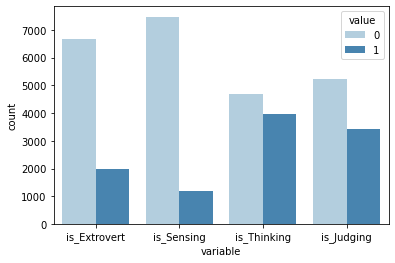

<IPython.core.display.Javascript object>

In [11]:
sns.countplot(
    x="variable",
    hue="value",
    data=pd.melt(
        personality_data[["is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging"]]
    ),
    palette="Blues",
)

plt.show()

The class imbalance issue still seem to exist but we will proceed with this for now. 

#### Checking for the presence of correlations

In [12]:
corr = personality_data[
    ["is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging"]
].corr()
corr.style.background_gradient(cmap="Blues").set_precision(4)

,is_Extrovert,is_Sensing,is_Thinking,is_Judging
is_Extrovert,1.0000,-0.0459,0.0696,-0.1619
is_Sensing,-0.0459,1.0000,0.0810,-0.0149
is_Thinking,0.0696,0.0810,1.0000,-0.0047
is_Judging,-0.1619,-0.0149,-0.0047,1.0000


<IPython.core.display.Javascript object>

There does not seem to be any strong correlation between the four personality dimenions.

### Feature Engineering - I

#### Data Cleaning

In [13]:
# converting posts into lower case
personality_data["clean_posts"] = personality_data["posts"].str.lower()

# replacing ||| with space
personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(
    re.compile(r"\|\|\|"), ""
)

# replacing urls with domain name
personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"),
    lambda match: match.group(2),
)

# dropping emails
personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(
    re.compile(r"\S+@\S+"), ""
)

# dropping punctuations
personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(
    re.compile(r"[^a-z\s]"), ""
)

# dropping MBTIs mentioned in the posts. There are quite a few mention of these types in these posts.
mbti = personality_data["type"].unique()
for type_word in mbti:
    personality_data["clean_posts"] = personality_data["clean_posts"].str.replace(
        type_word.lower(), ""
    )

<IPython.core.display.Javascript object>

In [14]:
personality_data.head()

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,youtube and moments youtube sportscenter no...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one youtube course to which i say i k...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed our conversation the other d...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...


<IPython.core.display.Javascript object>

#### Lemmitizing

* CAUTION - This will take long to run!!

In [15]:
# lemmitizing (excluding stop words in this step)

t = time.time()

lemmatizer = WordNetLemmatizer()

personality_data["clean_posts"] = personality_data["clean_posts"].apply(
    lambda x: " ".join(
        [
            lemmatizer.lemmatize(word)
            for word in x.split(" ")
            if word not in stopwords.words("english")
        ]
    )
)

print(f"Lemmitizing Time: {time.time() - t} seconds")

Lemmitizing Time: 4606.647078037262 seconds


<IPython.core.display.Javascript object>

In [16]:
personality_data.head()

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,youtube moment youtube sportscenter top ten...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,im finding lack post alarmingsex boring positi...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,good one youtube course say know thats ble...
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric gab...
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception a...


<IPython.core.display.Javascript object>

In [17]:
# lemmitizing took long. So saving the clean and lemmitized file to save time in further processing.
personality_data.to_csv("data_ekta/clean_data_1.csv", index=False)

<IPython.core.display.Javascript object>